In [1]:
import sys, os, glob
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
# from libs.activations import lrelu
import math
import numpy as np
import random as rnd

In [3]:
# %%
# load training image
train_images = np.load('train_images.npy')
print(train_images.shape)
# mean_img = np.mean(train_images, axis=0)
# print('mean_img.shape =', mean_img.shape)
# plt.figure()
# plt.imshow(mean_img[:, :, 0], cmap='gray')

# load training cmd
train_cmds = np.load("train_cmds.npy")
print(train_cmds.shape)
train_steps = train_cmds[:, 0]
train_angles = train_cmds[:, 1]
print(train_steps.shape, train_angles.shape)

# load training image2
train_images2 = np.load('train_images2.npy')
print(train_images2.shape)
# mean_img2 = np.mean(train_images2, axis=0)
# print('mean_img2.shape =', mean_img2.shape)
# plt.figure()
# plt.imshow(mean_img2[:, :, 0], cmap='gray')

# load training cmd2
train_cmds2 = np.load("train_cmds2.npy")
print(train_cmds2.shape)
train_steps2 = train_cmds2[:, 0]
train_angles2 = train_cmds2[:, 1]
print(train_steps2.shape, train_angles2.shape)

(40000, 40, 320, 1)
(39999, 3)
(39999,) (39999,)
(40000, 40, 320, 1)
(39999, 3)
(39999,) (39999,)


In [34]:
def add_encoder_layer(x, n_filters, filter_size, strides, deta=200.0):
    # %%
    # input to the network
#     x = tf.placeholder(tf.float32, input_shape, name='x')

    # %%
    # ensure input is 4-d.
    if len(x.get_shape()) != 4:
        raise ValueError('Unsupported input dimensions')
    input_shape = x.get_shape()
    print('The input layer x has shape', input_shape)
    
    # %%
    # Build the encoder
    n_input = x.get_shape().as_list()[3]
    n_output = n_filters
    W = tf.Variable(
            tf.random_uniform([filter_size[0], filter_size[1], n_input, n_output],
                -1.0 / math.sqrt(filter_size[0]*filter_size[1]*n_input),
                1.0 / math.sqrt(filter_size[0]*filter_size[1]*n_input)))
    b = tf.Variable(tf.zeros([n_output]))
    z = tf.nn.relu(tf.add(tf.nn.conv2d(x, W, strides=[1, strides[0], strides[1], 1], padding='VALID'), b))
    print('The encoding layer z has shape', z.get_shape())

    # %%
    # Build the decoder using the same weights
    b2 = tf.Variable(tf.zeros([n_input]))
    y = tf.nn.relu(tf.add(tf.nn.conv2d_transpose(z, W, input_shape, strides=[1, strides[0], strides[1], 1], padding='VALID'), b2))
    print('The output layer y has shape', y.get_shape())

    # %%
    # the reconstruction through the network
    # cost function measures pixel-wise difference
    cost = tf.reduce_sum(tf.square(y - x))
        
    l2_regularizer = tf.contrib.layers.l2_regularizer(scale=deta, scope=None)
#   weights = tf.trainable_variables()
    l2_cost = tf.contrib.layers.apply_regularization(l2_regularizer, [W])
        
    cost_t = cost + l2_cost

    # %%
    # define the optimizer
    learning_rate = 0.001
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost_t)
        
    # %%
    # dict for inputs, outputs, and costs
    ae = {'z': z, 'y': y, 'W': W, 'b': b, 'b2': b2, 'cost': cost, 'l2_cost': l2_cost, 'cost_t': cost_t, 'optimizer':optimizer}
        
    return ae

In [13]:
saved_model = 'modelxxx3'
example_num = 40

# %%
# Fit training data
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    input_shape = [example_num, 40, 320, 1]
    n_filters = 10
    filter_size = [8, 10]
    strides = [4, 5]
    x = tf.placeholder(tf.float32, input_shape, name='x')
    ae = add_encoder_layer(x, n_filters, filter_size, strides)
    
    sess = tf.Session()
    # initialize the weights or load the trained weights
#     sess.run(tf.global_variables_initializer())
    
    # reload the pretrained model
    restorer = tf.train.Saver()
    restorer.restore(sess, 'model/' + saved_model)

    n_epochs = 2
    for epoch_i in range(n_epochs):
        for batch_i in range(train_images.shape[0]-example_num):
            batch_xs = train_images[batch_i:(batch_i+example_num), :, :, :]
#             train = np.array([img - mean_img for img in batch_xs])
            train = batch_xs
            sess.run(ae['optimizer'], feed_dict={x: train})
            if batch_i % 1000 == 0:
                cost, l2_cost, cost_t = sess.run([ae['cost'], ae['l2_cost'], ae['cost_t']], feed_dict={x: train})
                print(epoch_i, ':1:', batch_i, ':cost =', cost, 'l2_cost =', l2_cost,  'cost_t =', cost_t)
        for batch_i in range(train_images.shape[0]-example_num):
            batch_xs = train_images2[batch_i:(batch_i+example_num), :, :, :]
#             train = np.array([img - mean_img2 for img in batch_xs])
            train = batch_xs
            sess.run(ae['optimizer'], feed_dict={x: train})
            if batch_i % 1000 == 0:
                cost, l2_cost, cost_t = sess.run([ae['cost'], ae['l2_cost'], ae['cost_t']], feed_dict={x: train})
                print(epoch_i, ':2:', batch_i, ':cost =', cost, 'l2_cost =', l2_cost,  'cost_t =', cost_t)

    saver = tf.train.Saver()
    save_path = saver.save(sess, 'model/' + saved_model)
    print("Model saved in file: %s" % save_path)

The input layer x has shape (40, 40, 320, 1)
The encoding layer z has shape (40, 9, 63, 10)
The output layer y has shape (40, 40, 320, 1)
INFO:tensorflow:Restoring parameters from model/modelxxx3
0 :1: 0 :cost = 1604.2 l2_cost = 543.995 cost_t = 2148.19
0 :1: 1000 :cost = 1266.58 l2_cost = 512.459 cost_t = 1779.04
0 :1: 2000 :cost = 1689.22 l2_cost = 528.638 cost_t = 2217.86
0 :1: 3000 :cost = 1345.42 l2_cost = 562.952 cost_t = 1908.37
0 :1: 4000 :cost = 1497.98 l2_cost = 547.136 cost_t = 2045.12
0 :1: 5000 :cost = 1523.24 l2_cost = 556.357 cost_t = 2079.6
0 :1: 6000 :cost = 1356.1 l2_cost = 535.516 cost_t = 1891.62
0 :1: 7000 :cost = 1268.84 l2_cost = 519.46 cost_t = 1788.3
0 :1: 8000 :cost = 1712.15 l2_cost = 577.839 cost_t = 2289.99
0 :1: 9000 :cost = 1544.44 l2_cost = 557.751 cost_t = 2102.19
0 :1: 10000 :cost = 1324.17 l2_cost = 535.671 cost_t = 1859.84
0 :1: 11000 :cost = 1521.35 l2_cost = 565.329 cost_t = 2086.68
0 :1: 12000 :cost = 1203.15 l2_cost = 525.887 cost_t = 1729.04
0 :

1 :2: 9000 :cost = 1246.97 l2_cost = 578.067 cost_t = 1825.03
1 :2: 10000 :cost = 1454.14 l2_cost = 573.017 cost_t = 2027.16
1 :2: 11000 :cost = 1310.58 l2_cost = 540.943 cost_t = 1851.52
1 :2: 12000 :cost = 1275.16 l2_cost = 527.085 cost_t = 1802.25
1 :2: 13000 :cost = 1307.02 l2_cost = 563.415 cost_t = 1870.43
1 :2: 14000 :cost = 1200.08 l2_cost = 569.253 cost_t = 1769.33
1 :2: 15000 :cost = 1146.3 l2_cost = 513.262 cost_t = 1659.56
1 :2: 16000 :cost = 1394.12 l2_cost = 545.652 cost_t = 1939.77
1 :2: 17000 :cost = 1413.83 l2_cost = 534.811 cost_t = 1948.64
1 :2: 18000 :cost = 1459.04 l2_cost = 557.097 cost_t = 2016.14
1 :2: 19000 :cost = 1350.51 l2_cost = 552.093 cost_t = 1902.6
1 :2: 20000 :cost = 1395.0 l2_cost = 571.236 cost_t = 1966.24
1 :2: 21000 :cost = 1182.97 l2_cost = 578.262 cost_t = 1761.23
1 :2: 22000 :cost = 1233.24 l2_cost = 558.655 cost_t = 1791.9
1 :2: 23000 :cost = 1298.13 l2_cost = 526.692 cost_t = 1824.82
1 :2: 24000 :cost = 1502.13 l2_cost = 589.729 cost_t = 2091.

The input layer x has shape (4, 40, 320, 1)
The encoding layer z has shape (4, 9, 63, 10)
The output layer y has shape (4, 40, 320, 1)
INFO:tensorflow:Restoring parameters from model/modelxxx3
[ 0.  0.  0.] [-10. -10. -10.]
[ 0.  0.  2.] [-10. -10.   0.]
(8, 40, 320, 1) (8, 40, 320, 1)


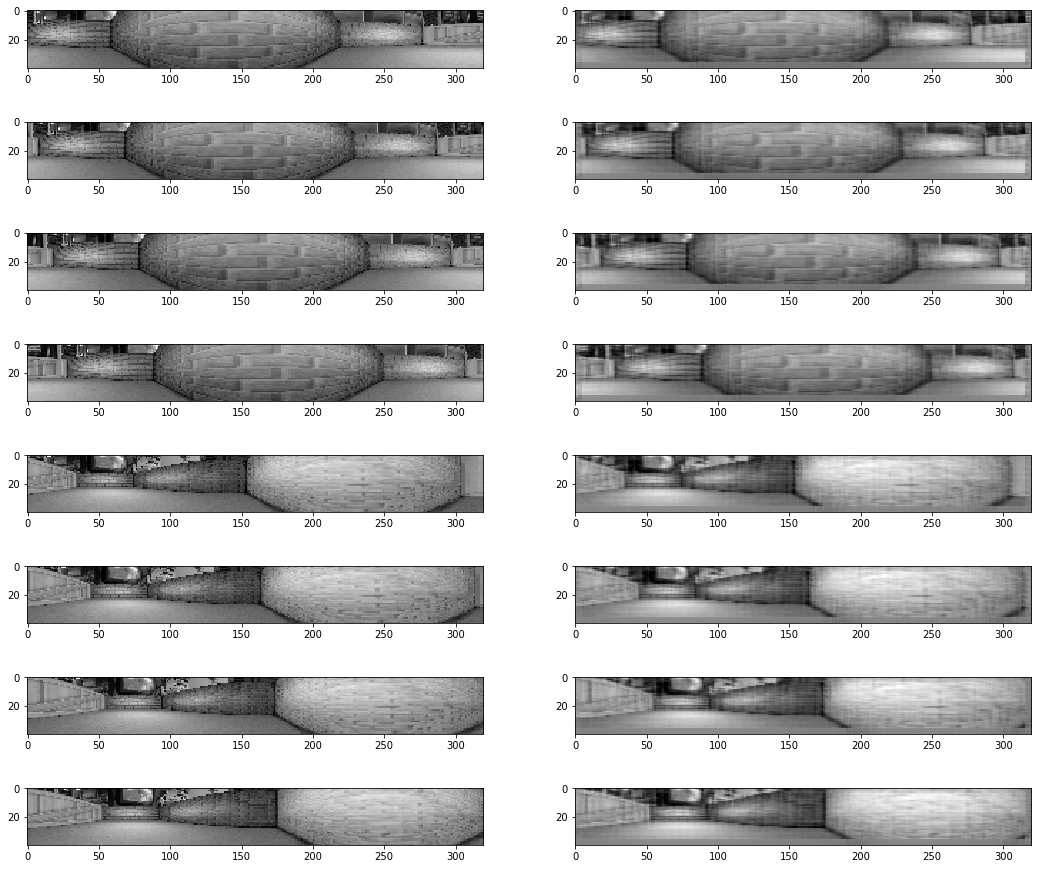

In [14]:
saved_model = 'modelxxx3'
example_num = 4

# %%
# Plot reconstruction example
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    input_shape = [example_num, 40, 320, 1]
    n_filters = 10
    filter_size = [8, 10]
    strides = [4, 5]
    x = tf.placeholder(tf.float32, input_shape, name='x')
    ae = add_encoder_layer(x, n_filters, filter_size, strides)
    
    sess = tf.Session()
    # reload the pretrained model
    restorer = tf.train.Saver()
    restorer.restore(sess, 'model/' + saved_model)

    start = int(rnd.random()*(40000-example_num-1))
    test_xs = train_images[start:(start+example_num), :, :, :]
#     test_xs_norm = np.array([img - mean_img for img in test_xs])
    test_xs_norm = test_xs
    steps_test = train_steps[start:(start+example_num-1)]
    angles_test = train_angles[start:(start+example_num-1)]
    print(steps_test, angles_test)
    recon = sess.run(ae['y'], feed_dict={x: test_xs_norm})

    test_xs2 = train_images2[start:(start+example_num), :, :, :]
#     test_xs_norm = np.array([img - mean_img2 for img in test_xs2])
    test_xs_norm = test_xs2
    steps_test = train_steps2[start:(start+example_num-1)]
    angles_test = train_angles2[start:(start+example_num-1)]
    print(steps_test, angles_test)
    recon2 = sess.run(ae['y'], feed_dict={x: test_xs_norm})

    test_xs = np.concatenate((test_xs, test_xs2), axis=0)
    recon = np.concatenate((recon, recon2), axis=0)
    print(test_xs.shape, recon.shape)
    fig, axs = plt.subplots(example_num*2, 2, figsize=(18, 4*example_num))
    for example_i in range(example_num*2):
        axs[example_i][0].imshow(test_xs[example_i, :, :, 0], cmap='gray')
        if example_i < example_num/2:
#             axs[example_i][1].imshow(recon[example_i, :, :, 0] + mean_img[:, :, 0], cmap='gray')
            axs[example_i][1].imshow(recon[example_i, :, :, 0], cmap='gray')
        else:
#             axs[example_i][1].imshow(recon[example_i, :, :, 0] + mean_img2[:, :, 0], cmap='gray')
            axs[example_i][1].imshow(recon[example_i, :, :, 0], cmap='gray')
    plt.show()

The input layer x has shape (40, 40, 320, 1)
The encoding layer z has shape (40, 9, 63, 10)
The output layer y has shape (40, 40, 320, 1)
INFO:tensorflow:Restoring parameters from model/modelxxx3
step commands are [ 0.  0.  0.  0.  2.  0.  0.  0.  0.  0.  2.  2.  2.  0.  0.  0.  0.  2.
  2.  2.  2.  2.  0.  0.  0.  0.  0.  2.  2.  2.  0.  0.  0.  2.  0.  2.
  0.  0.  0.]
angle commands are [ 10.  10.  10.  10.   0.  10.  10.  10.  10.  10.   0.   0.   0. -10. -10.
 -10. -10.   0.   0.   0.   0.   0.  10.  10.  10.  10.  10.   0.   0.   0.
  10.  10.  10.   0.  10.   0.  10.  10.  10.]
step commands are [ 0.  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.  2.  2.  2.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  2.  2.  0.
  0.  0.  0.]
angle commands are [-10. -10. -10. -10. -10. -10. -10. -10.   0. -10. -10.   0.   0.   0.  10.
  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.
  10.  10.   0.   0.   0. -10. -10. -10. -10.]
z1.shape = (

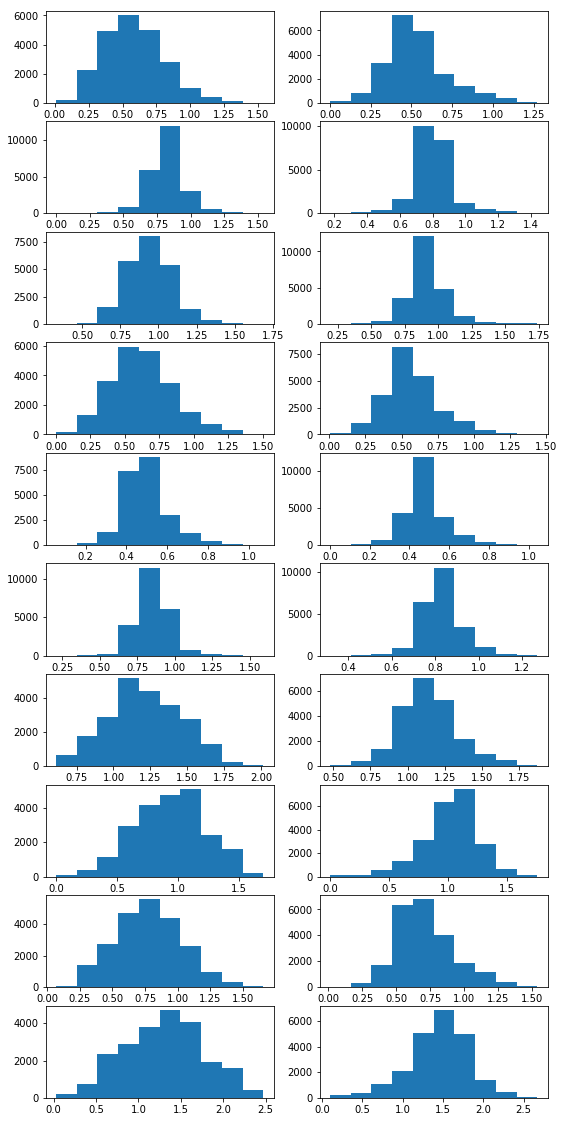

In [15]:
# %%
# Plot activation of neurons
saved_model = 'modelxxx3'
example_num = 40

# %%
# Plot reconstruction example
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    input_shape = [example_num, 40, 320, 1]
    n_filters = 10
    filter_size = [8, 10]
    strides = [4, 5]
    x = tf.placeholder(tf.float32, input_shape, name='x')
    ae = add_encoder_layer(x, n_filters, filter_size, strides)
    
    sess = tf.Session()
    restorer = tf.train.Saver()
    restorer.restore(sess, 'model/' + saved_model)
    
    start = int(rnd.random()*(40000-example_num-1))
    test_xs = train_images[start:(start+example_num), :, :, :]
    test_xs_norm = test_xs
    steps_test = train_steps[start:(start+example_num-1)]
    angles_test = train_angles[start:(start+example_num-1)]
    print('step commands are', steps_test)
    print('angle commands are', angles_test)
    z1 = sess.run(ae['z'], feed_dict={x: test_xs_norm})

    test_xs2 = train_images2[start:(start+example_num), :, :, :]
    test_xs_norm = test_xs2
    steps_test = train_steps2[start:(start+example_num-1)]
    angles_test = train_angles2[start:(start+example_num-1)]
    print('step commands are', steps_test)
    print('angle commands are', angles_test)
    z2 = sess.run(ae['z'], feed_dict={x: test_xs_norm})

    print('z1.shape =', z1.shape)
    print('z2.shape =', z2.shape)

shape = z1.shape.as_list()
tmp1 = np.reshape(z1, (shape[0]*shape[1]*shape[2], shape[3]))
# plt.hist(tmp1[:, 0])
tmp2 = np.reshape(z2, (shape[0]*shape[1]*shape[2], shape[3]))
fig, axes = plt.subplots(10, 2, figsize=(9, 20))
for idx in range(10):
    axes[idx, 0].hist(tmp1[:, idx])
    axes[idx, 1].hist(tmp2[:, idx])

### Get the pretained weights

The input layer x has shape (2, 40, 320, 1)
The encoding layer z has shape (2, 9, 63, 10)
The output layer y has shape (2, 40, 320, 1)
INFO:tensorflow:Restoring parameters from model/modelxxx3
w1.shape =  (8, 10, 1, 10) b1.shape =  (10,)
w1_val.shape = (8, 10, 1, 10)
max 0.188276 min -0.258297
max 0.195832 min -0.284833
max 0.269719 min -0.266409
max 0.165591 min -0.321095
max 0.17104 min -0.34666
max 0.295261 min -0.16514
max 0.186171 min -0.201123
max 0.25863 min -0.185888
max 0.18916 min -0.279841
max 0.261533 min -0.0690637


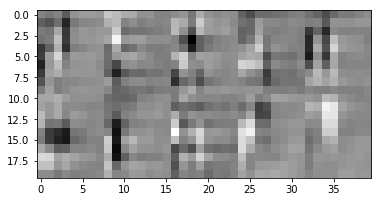

In [16]:
# %%
# Plot activation of neurons
saved_model = 'modelxxx3'
example_num = 2

# %%
# Plot reconstruction example
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    input_shape = [example_num, 40, 320, 1]
    n_filters = 10
    filter_size = [8, 10]
    strides = [4, 5]
    x = tf.placeholder(tf.float32, input_shape, name='x')
    ae = add_encoder_layer(x, n_filters, filter_size, strides)
    
    sess = tf.Session()
    restorer = tf.train.Saver()
    restorer.restore(sess, 'model/' + saved_model)
    
    w1, b1 = sess.run([ae['W'], ae['b']])
    print('w1.shape = ', w1.shape, 'b1.shape = ', b1.shape)
    np.save('model/w1.npy', w1)
    np.save('model/b1.npy', b1)
    
w1_val = np.load('model/w1.npy')
print('w1_val.shape =', w1_val.shape)
h = w1_val.shape[0]
w = w1_val.shape[1]
wi_image = np.zeros([h*5, w*2])
for i in range(5):
    for j in range(2):
        wi_image[i*h:(i+1)*h, j*w:(j+1)*w] = w1_val[:, :, 0, 2*i+j]
        print('max', np.max(w1_val[:, :, 0, 2*i+j]), 'min', np.min(w1_val[:, :, 0, 2*i+j]))
plt.imshow(np.transpose(wi_image), cmap='gray')

### Build the Predict Layer

In [2]:
def add_encoder_layer_with_weight(x, weight_file, bias_file, strides):
    
    # %%
    # ensure input is 4-d.
    if len(x.get_shape()) != 4:
        raise ValueError('Unsupported input dimensions')
    input_shape = x.get_shape()
    print('The input layer x has shape', input_shape)
    
    # %%
    # Build the encoder
    W_val = np.load('model/' + weight_file)
    W = tf.constant(W_val)
    b_val = np.load('model/' + bias_file)
    b = tf.constant(b_val)
    z = tf.nn.relu(tf.add(tf.nn.conv2d(x, W, strides=[1, strides[0], strides[1], 1], padding='VALID'), b))
    print('The encoding layer z has shape', z.get_shape())
        
    # %%
    # dict for inputs, outputs, and costs
    ae = {'z': z}
        
    return ae

def add_predict_layer(encode_layer_t1, encode_layer_t2, filter_size, strides, head_cell_n, place_cell_n):
    
    print('encode_layer_t1 has shape =', encode_layer_t1.get_shape())
    print('encode_layer_t2 has shape =', encode_layer_t2.get_shape())
    shape = encode_layer_t1.get_shape()
    n_input = shape.as_list()[3]
#     print(n_input)
    
    # %%
    # Build head cells
    n_output = head_cell_n
    w2 = tf.Variable(tf.random_uniform([filter_size[0], filter_size[1], n_input, n_output],
                                       -1.0/math.sqrt(n_input), 1.0/math.sqrt(n_input)))
    b2 = tf.Variable(tf.zeros([n_output]))
    head_layer_t1 = tf.nn.relu(tf.add(
        tf.nn.conv2d(encode_layer_t1, w2, strides=[1, strides[0], strides[1], 1], padding='VALID'), b2))
    print('head_layer_t1 has shape =', head_layer_t1.get_shape())
    
    # %%
    # predict encode_layer_t2 using head_layer_t1
    b2_2 = tf.Variable(tf.zeros([n_input]))
    encode_layer_t2_H = tf.nn.relu(tf.add(
        tf.nn.conv2d_transpose(head_layer_t1, w2, shape, strides=[1, strides[0], strides[1], 1], padding='VALID'), b2_2))
    print('encode_layer_t2_H has shape =', encode_layer_t2_H.get_shape())
    # %%
    # cost function measures pixel-wise difference
    cost1 = tf.reduce_sum(tf.square(encode_layer_t2_H - encode_layer_t2))
    
    # %%
    # Build place cells
    n_output = place_cell_n
    w3 = tf.Variable(tf.random_uniform([filter_size[0], filter_size[1], n_input, n_output],
                                       -1.0/math.sqrt(n_input), 1.0/math.sqrt(n_input)))
    b3 = tf.Variable(tf.zeros([n_output]))
    place_layer_t1 = tf.nn.relu(tf.add(
        tf.nn.conv2d(encode_layer_t1, w3, strides=[1, strides[0], strides[1], 1], padding='VALID'), b3))
    print('place_layer_t1 has shape =', place_layer_t1.get_shape())
    
    # %%
    # predict Code_layer_1_t2 using head_layer_1_t1
    b3_2 = tf.Variable(tf.zeros([n_input]))
    encode_layer_t2_P = tf.nn.relu(tf.add(
        tf.nn.conv2d_transpose(place_layer_t1, w3, shape, strides=[1, strides[0], strides[1], 1], padding='VALID'), b3_2))
    print('encode_layer_t2_P has shape =', encode_layer_t2_P.get_shape())
    # %%
    # cost function measures pixel-wise difference
    cost2 = tf.reduce_sum(tf.square(encode_layer_t2_P - encode_layer_t2))

    # %%
    # define the optimizer
    learning_rate = 0.001
    optimizer1 = tf.train.AdamOptimizer(learning_rate).minimize(cost1, var_list=[w2, b2, b2_2])
    optimizer2 = tf.train.AdamOptimizer(learning_rate).minimize(cost2, var_list=[w3, b3, b3_2])
        
    # %%
    # dict for inputs, outputs, and costs
    pred = {'w2': w2, 'b2': b2, 'w3': w3, 'b3': b3, 'cost1': cost1, 'cost2': cost2, \
            'head_layer_t1': head_layer_t1, 'place_layer_t1': place_layer_t1, 'optimizer1': optimizer1, 'optimizer2': optimizer2}
        
    return pred

def add_predict_layer_with_weight(x, H_weight_file, H_bias_file, P_weight_file, P_bias_file, strides):
    
    # %%
    # ensure input is 4-d.
    if len(x.get_shape()) != 4:
        raise ValueError('Unsupported input dimensions')
    input_shape = x.get_shape()
    print('The input layer x has shape', input_shape)
    
    # %%
    # Build the head layer
    H_W_val = np.load('model/' + H_weight_file)
    H_W = tf.constant(H_W_val)
    H_b_val = np.load('model/' + H_bias_file)
    H_b = tf.constant(H_b_val)
    head_layer = tf.nn.relu(tf.add(tf.nn.conv2d(x, H_W, strides=[1, strides[0], strides[1], 1], padding='VALID'), H_b))
    print('The head_layer has shape', head_layer.get_shape())
    
    # %%
    # Build the place layer
    P_W_val = np.load('model/' + P_weight_file)
    P_W = tf.constant(P_W_val)
    P_b_val = np.load('model/' + P_bias_file)
    P_b = tf.constant(P_b_val)
    place_layer = tf.nn.relu(tf.add(tf.nn.conv2d(x, P_W, strides=[1, strides[0], strides[1], 1], padding='VALID'), P_b))
    print('The place_layer has shape', place_layer.get_shape())
        
    z = tf.concat([head_layer, place_layer], 3)
    print('The layer z has shape', z.get_shape())
    
    # %%
    # dict for inputs, outputs, and costs
    ae = {'z': z, 'z1': head_layer, 'z2': place_layer}
        
    return ae

In [29]:
saved_model = 'modelxxx4'
example_num = 1

# %%
# Fit training data
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    input_shape = [example_num, 40, 320, 1]
    weight_file = 'w1.npy'
    bias_file = 'b1.npy'
    strides = [4, 5]
    x1 = tf.placeholder(tf.float32, input_shape, name='x1')
    x2 = tf.placeholder(tf.float32, input_shape, name='x2')
    ae1 = add_encoder_layer_with_weight(x1, weight_file, bias_file, strides)
    ae2 = add_encoder_layer_with_weight(x2, weight_file, bias_file, strides)
    
    filter_size = [3, 3]
    strides = [3, 3]
    head_cell_n = 40
    place_cell_n = 30
    pred = add_predict_layer(ae1['z'], ae2['z'], filter_size, strides, head_cell_n, place_cell_n)
    
    sess = tf.Session()
    
    # initialize the weights or load the trained weights
#     sess.run(tf.global_variables_initializer())
    
    restorer = tf.train.Saver()
    restorer.restore(sess, 'model/' + saved_model)

    n_epochs = 1
    for epoch_i in range(n_epochs):
        for batch_i in range(train_images.shape[0]-1):
            train1 = train_images[batch_i:(batch_i+example_num), :, :, :]
            train2 = train_images[batch_i+1:(batch_i+1+example_num), :, :, :]
            train_step = train_steps[batch_i]
            train_angle = train_angles[batch_i]
            if train_step != 0:
                sess.run(pred['optimizer1'], feed_dict={x1: train1, x2: train2})
            if train_angle != 0:
                sess.run(pred['optimizer2'], feed_dict={x1: train1, x2: train2})
            if batch_i % 10000 == 0:
                cost1_val, cost2_val = sess.run([pred['cost1'], pred['cost2']], feed_dict={x1: train1, x2: train2})
                print(epoch_i, ':', batch_i, 'step = ', train_step, 'angle =', train_angle, ':1:cost1 =', cost1_val, "cost2 =", cost2_val)
        for batch_i in range(train_images.shape[0]-1):
            train1 = train_images2[batch_i:(batch_i+example_num), :, :, :]
            train2 = train_images2[batch_i+1:(batch_i+1+example_num), :, :, :]
            train_step = train_steps2[batch_i]
            train_angle = train_angles2[batch_i]
            if train_step != 0:
                sess.run(pred['optimizer1'], feed_dict={x1: train1, x2: train2})
            if train_angle != 0:
                sess.run(pred['optimizer2'], feed_dict={x1: train1, x2: train2})
            if batch_i % 10000 == 0:
                cost1_val, cost2_val = sess.run([pred['cost1'], pred['cost2']], feed_dict={x1: train1, x2: train2})
                print(epoch_i, ':', batch_i, 'step = ', train_step, 'angle =', train_angle, ':1:cost1 =', cost1_val, "cost2 =", cost2_val)

    w2, b2, w3, b3 = sess.run([pred['w2'], pred['b2'], pred['w3'], pred['b3']])
    print('w2.shape = ', w2.shape, 'b2.shape = ', b2.shape, 'w3.shape = ', w3.shape, 'b3.shape = ', b3.shape)
    np.save('model/w2.npy', w2)
    np.save('model/b2.npy', b2)
    np.save('model/w3.npy', w3)
    np.save('model/b3.npy', b3)
    
    saver = tf.train.Saver()
    save_path = saver.save(sess, 'model/' + saved_model)
    print("Model saved in file: %s" % save_path)

The input layer x has shape (1, 40, 320, 1)
The encoding layer z has shape (1, 9, 63, 10)
The input layer x has shape (1, 40, 320, 1)
The encoding layer z has shape (1, 9, 63, 10)
encode_layer_t1 has shape = (1, 9, 63, 10)
encode_layer_t2 has shape = (1, 9, 63, 10)
10
head_layer_t1 has shape = (1, 3, 21, 40)
encode_layer_t2_H has shape = (1, 9, 63, 10)
place_layer_t1 has shape = (1, 3, 21, 30)
encode_layer_t2_P has shape = (1, 9, 63, 10)
INFO:tensorflow:Restoring parameters from model/modelxxx4
0 : 0 step =  1.99999999998 angle = 0.0 :1:cost1 = 39.6295 cost2 = 55.6235
0 : 10000 step =  0.0 angle = -10.0 :1:cost1 = 99.549 cost2 = 78.7356
0 : 20000 step =  0.0 angle = 9.99999999998 :1:cost1 = 174.562 cost2 = 145.045
0 : 30000 step =  0.0 angle = -10.0 :1:cost1 = 149.694 cost2 = 122.162
0 : 0 step =  0.0 angle = 9.99999999998 :1:cost1 = 171.09 cost2 = 142.497
0 : 10000 step =  0.0 angle = 10.0 :1:cost1 = 175.345 cost2 = 139.356
0 : 20000 step =  0.0 angle = -9.99999999997 :1:cost1 = 124.3

In [36]:
saved_model = 'modelxxx5'
example_num = 40

# %%
# Fit training data
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    input_shape = [example_num, 40, 320, 1]
    weight_file = 'w1.npy'
    bias_file = 'b1.npy'
    strides = [4, 5]
    x = tf.placeholder(tf.float32, input_shape, name='x')
    ae1 = add_encoder_layer_with_weight(x, weight_file, bias_file, strides)
    
    H_weight_file = 'w2.npy'
    H_bias_file = 'b2.npy'
    P_weight_file = 'w3.npy'
    P_bias_file = 'b3.npy'
    strides = [3, 3]
    pred1 = add_predict_layer_with_weight(ae1['z'], H_weight_file, H_bias_file, P_weight_file, P_bias_file, strides)
    
    n_filters = 70
    filter_size = [3, 3]
    strides = [1, 1]
    ae = add_encoder_layer(pred1['z'], n_filters, filter_size, strides, 10.0)
    
    sess = tf.Session()
    # initialize the weights or load the trained weights
    sess.run(tf.global_variables_initializer())
    
    # reload the pretrained model
#     restorer = tf.train.Saver()
#     restorer.restore(sess, 'model/' + saved_model)

    n_epochs = 2
    for epoch_i in range(n_epochs):
        for batch_i in range(train_images.shape[0]-example_num):
            batch_xs = train_images[batch_i:(batch_i+example_num), :, :, :]
#             train = np.array([img - mean_img for img in batch_xs])
            train = batch_xs
            sess.run(ae['optimizer'], feed_dict={x: train})
            if batch_i % 1000 == 0:
                cost, l2_cost, cost_t = sess.run([ae['cost'], ae['l2_cost'], ae['cost_t']], feed_dict={x: train})
                print(epoch_i, ':1:', batch_i, ':cost =', cost, 'l2_cost =', l2_cost,  'cost_t =', cost_t)
        for batch_i in range(train_images.shape[0]-example_num):
            batch_xs = train_images2[batch_i:(batch_i+example_num), :, :, :]
#             train = np.array([img - mean_img2 for img in batch_xs])
            train = batch_xs
            sess.run(ae['optimizer'], feed_dict={x: train})
            if batch_i % 1000 == 0:
                cost, l2_cost, cost_t = sess.run([ae['cost'], ae['l2_cost'], ae['cost_t']], feed_dict={x: train})
                print(epoch_i, ':2:', batch_i, ':cost =', cost, 'l2_cost =', l2_cost,  'cost_t =', cost_t)
    
    w4, b4 = sess.run([ae['W'], ae['b']])
    print('w4.shape = ', w4.shape, 'b4.shape = ', b4.shape)
    np.save('model/w4.npy', w4)
    np.save('model/b4.npy', b4)

    saver = tf.train.Saver()
    save_path = saver.save(sess, 'model/' + saved_model)
    print("Model saved in file: %s" % save_path)

The input layer x has shape (40, 40, 320, 1)
The encoding layer z has shape (40, 9, 63, 10)
The input layer x has shape (40, 9, 63, 10)
The head_layer has shape (40, 3, 21, 40)
The place_layer has shape (40, 3, 21, 30)
The layer z has shape (40, 3, 21, 70)
The input layer x has shape (40, 3, 21, 70)
The encoding layer z has shape (40, 1, 19, 70)
The output layer y has shape (40, 3, 21, 70)
0 :1: 0 :cost = 72354.1 l2_cost = 563.798 cost_t = 72917.9
0 :1: 1000 :cost = 3083.69 l2_cost = 364.25 cost_t = 3447.94
0 :1: 2000 :cost = 1995.18 l2_cost = 371.543 cost_t = 2366.72
0 :1: 3000 :cost = 1543.59 l2_cost = 368.207 cost_t = 1911.8
0 :1: 4000 :cost = 1165.9 l2_cost = 379.411 cost_t = 1545.31
0 :1: 5000 :cost = 1430.99 l2_cost = 386.973 cost_t = 1817.96
0 :1: 6000 :cost = 1076.8 l2_cost = 358.164 cost_t = 1434.96
0 :1: 7000 :cost = 934.168 l2_cost = 345.784 cost_t = 1279.95
0 :1: 8000 :cost = 1289.41 l2_cost = 391.396 cost_t = 1680.8
0 :1: 9000 :cost = 991.016 l2_cost = 374.772 cost_t = 136

1 :2: 6000 :cost = 958.66 l2_cost = 348.219 cost_t = 1306.88
1 :2: 7000 :cost = 996.596 l2_cost = 338.534 cost_t = 1335.13
1 :2: 8000 :cost = 1023.7 l2_cost = 338.411 cost_t = 1362.12
1 :2: 9000 :cost = 1066.93 l2_cost = 368.819 cost_t = 1435.75
1 :2: 10000 :cost = 1188.72 l2_cost = 383.137 cost_t = 1571.86
1 :2: 11000 :cost = 877.058 l2_cost = 364.961 cost_t = 1242.02
1 :2: 12000 :cost = 1222.12 l2_cost = 340.636 cost_t = 1562.76
1 :2: 13000 :cost = 1058.34 l2_cost = 355.188 cost_t = 1413.53
1 :2: 14000 :cost = 1128.73 l2_cost = 348.707 cost_t = 1477.44
1 :2: 15000 :cost = 801.978 l2_cost = 337.405 cost_t = 1139.38
1 :2: 16000 :cost = 1016.15 l2_cost = 354.154 cost_t = 1370.3
1 :2: 17000 :cost = 1032.86 l2_cost = 345.402 cost_t = 1378.26
1 :2: 18000 :cost = 979.553 l2_cost = 361.666 cost_t = 1341.22
1 :2: 19000 :cost = 1000.7 l2_cost = 349.284 cost_t = 1349.99
1 :2: 20000 :cost = 1033.78 l2_cost = 369.962 cost_t = 1403.74
1 :2: 21000 :cost = 1080.2 l2_cost = 363.753 cost_t = 1443.95
1

The input layer x has shape (40, 40, 320, 1)
The encoding layer z has shape (40, 9, 63, 10)
The input layer x has shape (40, 9, 63, 10)
The head_layer has shape (40, 3, 21, 40)
The place_layer has shape (40, 3, 21, 30)
The layer z has shape (40, 3, 21, 70)
The input layer x has shape (40, 3, 21, 70)
The encoding layer z has shape (40, 1, 19, 70)
The output layer y has shape (40, 3, 21, 70)
INFO:tensorflow:Restoring parameters from model/modelxxx5
step commands are [ 0.  2.  2.  0.  0.  0.  0.  0.  2.  2.  2.  2.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.  0.  0.  2.  0.  0.  0.  0.  0.
  0.  0.  0.]
angle commands are [-10.   0.   0.  10.  10.  10.  10.  10.   0.   0.   0.   0.  10.  10.  10.
  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.   0.  10.  10.  10.  10.
   0. -10. -10. -10. -10. -10. -10. -10. -10.]
step commands are [ 0.  0.  0.  2.  2.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  2.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  2.  2.  0.  0.  0.  

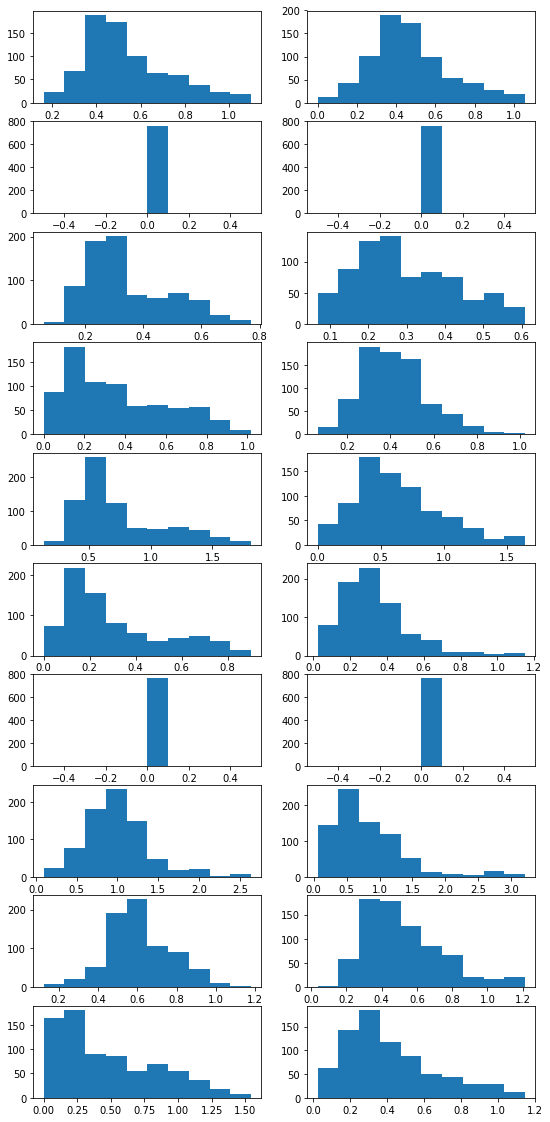

In [39]:
# %%
# Plot activation of neurons
saved_model = 'modelxxx5'
example_num = 40

# %%
# Fit training data
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    input_shape = [example_num, 40, 320, 1]
    weight_file = 'w1.npy'
    bias_file = 'b1.npy'
    strides = [4, 5]
    x = tf.placeholder(tf.float32, input_shape, name='x')
    ae1 = add_encoder_layer_with_weight(x, weight_file, bias_file, strides)
    
    H_weight_file = 'w2.npy'
    H_bias_file = 'b2.npy'
    P_weight_file = 'w3.npy'
    P_bias_file = 'b3.npy'
    strides = [3, 3]
    pred1 = add_predict_layer_with_weight(ae1['z'], H_weight_file, H_bias_file, P_weight_file, P_bias_file, strides)
    
    n_filters = 70
    filter_size = [3, 3]
    strides = [1, 1]
    ae = add_encoder_layer(pred1['z'], n_filters, filter_size, strides)
    
    sess = tf.Session()
    
    # reload the pretrained model
    restorer = tf.train.Saver()
    restorer.restore(sess, 'model/' + saved_model)
    
    start = int(rnd.random()*(40000-example_num-1))
    test_xs = train_images[start:(start+example_num), :, :, :]
    test_xs_norm = test_xs
    steps_test = train_steps[start:(start+example_num-1)]
    angles_test = train_angles[start:(start+example_num-1)]
    print('step commands are', steps_test)
    print('angle commands are', angles_test)
    z1 = sess.run(ae['z'], feed_dict={x: test_xs_norm})

    test_xs2 = train_images2[start:(start+example_num), :, :, :]
    test_xs_norm = test_xs2
    steps_test = train_steps2[start:(start+example_num-1)]
    angles_test = train_angles2[start:(start+example_num-1)]
    print('step commands are', steps_test)
    print('angle commands are', angles_test)
    z2 = sess.run(ae['z'], feed_dict={x: test_xs_norm})

    print('z1.shape =', z1.shape)
    print('z2.shape =', z2.shape)

shape = z1.shape
tmp1 = np.reshape(z1, (shape[0]*shape[1]*shape[2], shape[3]))
# plt.hist(tmp1[:, 0])
tmp2 = np.reshape(z2, (shape[0]*shape[1]*shape[2], shape[3]))
fig, axes = plt.subplots(10, 2, figsize=(9, 20))
for idx in range(10):
    axes[idx, 0].hist(tmp1[:, idx])
    axes[idx, 1].hist(tmp2[:, idx])

In [40]:
saved_model = 'modelxxx6'
example_num = 1

# %%
# Fit training data
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    input_shape = [example_num, 40, 320, 1]
    weight_file = 'w1.npy'
    bias_file = 'b1.npy'
    strides = [4, 5]
    x1 = tf.placeholder(tf.float32, input_shape, name='x1')
    x2 = tf.placeholder(tf.float32, input_shape, name='x2')
    ae1_1 = add_encoder_layer_with_weight(x1, weight_file, bias_file, strides)
    ae1_2 = add_encoder_layer_with_weight(x2, weight_file, bias_file, strides)
    
    H_weight_file = 'w2.npy'
    H_bias_file = 'b2.npy'
    P_weight_file = 'w3.npy'
    P_bias_file = 'b3.npy'
    strides = [3, 3]
    pred1_1 = add_predict_layer_with_weight(ae1_1['z'], H_weight_file, H_bias_file, P_weight_file, P_bias_file, strides)
    pred1_2 = add_predict_layer_with_weight(ae1_2['z'], H_weight_file, H_bias_file, P_weight_file, P_bias_file, strides)
    
    weight_file = 'w4.npy'
    bias_file = 'b4.npy'
    strides = [1, 1]
    ae2_1 = add_encoder_layer_with_weight(pred1_1['z'], weight_file, bias_file, strides)
    ae2_2 = add_encoder_layer_with_weight(pred1_2['z'], weight_file, bias_file, strides)
    
    filter_size = [1, 5]
    strides = [1, 1]
    head_cell_n = 40
    place_cell_n = 30
    pred = add_predict_layer(ae2_1['z'], ae2_2['z'], filter_size, strides, head_cell_n, place_cell_n)
    
    sess = tf.Session()
    
    # initialize the weights or load the trained weights
    sess.run(tf.global_variables_initializer())
    
#     restorer = tf.train.Saver()
#     restorer.restore(sess, 'model/' + saved_model)

    n_epochs = 10
    for epoch_i in range(n_epochs):
        for batch_i in range(train_images.shape[0]-1):
            train1 = train_images[batch_i:(batch_i+example_num), :, :, :]
            train2 = train_images[batch_i+1:(batch_i+1+example_num), :, :, :]
            train_step = train_steps[batch_i]
            train_angle = train_angles[batch_i]
            if train_step != 0:
                sess.run(pred['optimizer1'], feed_dict={x1: train1, x2: train2})
            if train_angle != 0:
                sess.run(pred['optimizer2'], feed_dict={x1: train1, x2: train2})
            if batch_i % 10000 == 0:
                cost1_val, cost2_val = sess.run([pred['cost1'], pred['cost2']], feed_dict={x1: train1, x2: train2})
                print(epoch_i, ':', batch_i, 'step = ', train_step, 'angle =', train_angle, ':1:cost1 =', cost1_val, "cost2 =", cost2_val)
        for batch_i in range(train_images.shape[0]-1):
            train1 = train_images2[batch_i:(batch_i+example_num), :, :, :]
            train2 = train_images2[batch_i+1:(batch_i+1+example_num), :, :, :]
            train_step = train_steps2[batch_i]
            train_angle = train_angles2[batch_i]
            if train_step != 0:
                sess.run(pred['optimizer1'], feed_dict={x1: train1, x2: train2})
            if train_angle != 0:
                sess.run(pred['optimizer2'], feed_dict={x1: train1, x2: train2})
            if batch_i % 10000 == 0:
                cost1_val, cost2_val = sess.run([pred['cost1'], pred['cost2']], feed_dict={x1: train1, x2: train2})
                print(epoch_i, ':', batch_i, 'step = ', train_step, 'angle =', train_angle, ':1:cost1 =', cost1_val, "cost2 =", cost2_val)

    w5, b5, w6, b6 = sess.run([pred['w2'], pred['b2'], pred['w3'], pred['b3']])
    print('w5.shape = ', w5.shape, 'b5.shape = ', b5.shape, 'w6.shape = ', w6.shape, 'b6.shape = ', b6.shape)
    np.save('model/w5.npy', w5)
    np.save('model/b5.npy', b5)
    np.save('model/w6.npy', w6)
    np.save('model/b6.npy', b6)
    
    saver = tf.train.Saver()
    save_path = saver.save(sess, 'model/' + saved_model)
    print("Model saved in file: %s" % save_path)

The input layer x has shape (1, 40, 320, 1)
The encoding layer z has shape (1, 9, 63, 10)
The input layer x has shape (1, 40, 320, 1)
The encoding layer z has shape (1, 9, 63, 10)
The input layer x has shape (1, 9, 63, 10)
The head_layer has shape (1, 3, 21, 40)
The place_layer has shape (1, 3, 21, 30)
The layer z has shape (1, 3, 21, 70)
The input layer x has shape (1, 9, 63, 10)
The head_layer has shape (1, 3, 21, 40)
The place_layer has shape (1, 3, 21, 30)
The layer z has shape (1, 3, 21, 70)
The input layer x has shape (1, 3, 21, 70)
The encoding layer z has shape (1, 1, 19, 70)
The input layer x has shape (1, 3, 21, 70)
The encoding layer z has shape (1, 1, 19, 70)
encode_layer_t1 has shape = (1, 1, 19, 70)
encode_layer_t2 has shape = (1, 1, 19, 70)
head_layer_t1 has shape = (1, 1, 15, 40)
encode_layer_t2_H has shape = (1, 1, 19, 70)
place_layer_t1 has shape = (1, 1, 15, 30)
encode_layer_t2_P has shape = (1, 1, 19, 70)
0 : 0 step =  1.99999999998 angle = 0.0 :1:cost1 = 1226.13 co

In [43]:
saved_model = 'modelxxx7'
example_num = 40

# %%
# Fit training data
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    input_shape = [example_num, 40, 320, 1]
    weight_file = 'w1.npy'
    bias_file = 'b1.npy'
    strides = [4, 5]
    x = tf.placeholder(tf.float32, input_shape, name='x')
    ae1 = add_encoder_layer_with_weight(x, weight_file, bias_file, strides)
    
    H_weight_file = 'w2.npy'
    H_bias_file = 'b2.npy'
    P_weight_file = 'w3.npy'
    P_bias_file = 'b3.npy'
    strides = [3, 3]
    pred1 = add_predict_layer_with_weight(ae1['z'], H_weight_file, H_bias_file, P_weight_file, P_bias_file, strides)
    
    weight_file = 'w4.npy'
    bias_file = 'b4.npy'
    strides = [1, 1]
    ae2 = add_encoder_layer_with_weight(pred1['z'], weight_file, bias_file, strides)
    
    H_weight_file = 'w5.npy'
    H_bias_file = 'b5.npy'
    P_weight_file = 'w6.npy'
    P_bias_file = 'b6.npy'
    strides = [1, 1]
    pred2 = add_predict_layer_with_weight(ae2['z'], H_weight_file, H_bias_file, P_weight_file, P_bias_file, strides)
    
    n_filters = 70
    filter_size = [1, 8]
    strides = [1, 1]
    ae = add_encoder_layer(pred2['z'], n_filters, filter_size, strides, 0.5)
    
    sess = tf.Session()
    # initialize the weights or load the trained weights
#     sess.run(tf.global_variables_initializer())
    
    # reload the pretrained model
    restorer = tf.train.Saver()
    restorer.restore(sess, 'model/' + saved_model)

    n_epochs = 2
    for epoch_i in range(n_epochs):
        for batch_i in range(train_images.shape[0]-example_num):
            batch_xs = train_images[batch_i:(batch_i+example_num), :, :, :]
#             train = np.array([img - mean_img for img in batch_xs])
            train = batch_xs
            sess.run(ae['optimizer'], feed_dict={x: train})
            if batch_i % 1000 == 0:
                cost, l2_cost, cost_t = sess.run([ae['cost'], ae['l2_cost'], ae['cost_t']], feed_dict={x: train})
                print(epoch_i, ':1:', batch_i, ':cost =', cost, 'l2_cost =', l2_cost,  'cost_t =', cost_t)
        for batch_i in range(train_images.shape[0]-example_num):
            batch_xs = train_images2[batch_i:(batch_i+example_num), :, :, :]
#             train = np.array([img - mean_img2 for img in batch_xs])
            train = batch_xs
            sess.run(ae['optimizer'], feed_dict={x: train})
            if batch_i % 1000 == 0:
                cost, l2_cost, cost_t = sess.run([ae['cost'], ae['l2_cost'], ae['cost_t']], feed_dict={x: train})
                print(epoch_i, ':2:', batch_i, ':cost =', cost, 'l2_cost =', l2_cost,  'cost_t =', cost_t)
    
    w7, b7 = sess.run([ae['W'], ae['b']])
    print('w7.shape = ', w7.shape, 'b7.shape = ', b7.shape)
    np.save('model/w7.npy', w7)
    np.save('model/b7.npy', b7)

    saver = tf.train.Saver()
    save_path = saver.save(sess, 'model/' + saved_model)
    print("Model saved in file: %s" % save_path)

The input layer x has shape (40, 40, 320, 1)
The encoding layer z has shape (40, 9, 63, 10)
The input layer x has shape (40, 9, 63, 10)
The head_layer has shape (40, 3, 21, 40)
The place_layer has shape (40, 3, 21, 30)
The layer z has shape (40, 3, 21, 70)
The input layer x has shape (40, 3, 21, 70)
The encoding layer z has shape (40, 1, 19, 70)
The input layer x has shape (40, 1, 19, 70)
The head_layer has shape (40, 1, 15, 40)
The place_layer has shape (40, 1, 15, 30)
The layer z has shape (40, 1, 15, 70)
The input layer x has shape (40, 1, 15, 70)
The encoding layer z has shape (40, 1, 8, 70)
The output layer y has shape (40, 1, 15, 70)
INFO:tensorflow:Restoring parameters from model/modelxxx7
0 :1: 0 :cost = 1095.22 l2_cost = 7.319 cost_t = 1102.54
0 :1: 1000 :cost = 411.177 l2_cost = 7.3636 cost_t = 418.541
0 :1: 2000 :cost = 526.516 l2_cost = 7.23818 cost_t = 533.754
0 :1: 3000 :cost = 415.935 l2_cost = 7.3809 cost_t = 423.316
0 :1: 4000 :cost = 469.563 l2_cost = 7.15674 cost_t =

1 :2: 1000 :cost = 378.748 l2_cost = 7.21989 cost_t = 385.968
1 :2: 2000 :cost = 462.167 l2_cost = 7.23411 cost_t = 469.401
1 :2: 3000 :cost = 452.466 l2_cost = 7.18689 cost_t = 459.653
1 :2: 4000 :cost = 452.927 l2_cost = 7.375 cost_t = 460.302
1 :2: 5000 :cost = 507.259 l2_cost = 7.41128 cost_t = 514.67
1 :2: 6000 :cost = 404.96 l2_cost = 7.17193 cost_t = 412.132
1 :2: 7000 :cost = 430.813 l2_cost = 7.0942 cost_t = 437.907
1 :2: 8000 :cost = 360.487 l2_cost = 7.21026 cost_t = 367.697
1 :2: 9000 :cost = 457.879 l2_cost = 7.14555 cost_t = 465.025
1 :2: 10000 :cost = 499.857 l2_cost = 7.29233 cost_t = 507.149
1 :2: 11000 :cost = 309.605 l2_cost = 7.3261 cost_t = 316.931
1 :2: 12000 :cost = 554.962 l2_cost = 7.27013 cost_t = 562.232
1 :2: 13000 :cost = 539.01 l2_cost = 7.1328 cost_t = 546.142
1 :2: 14000 :cost = 508.533 l2_cost = 7.15257 cost_t = 515.685
1 :2: 15000 :cost = 420.721 l2_cost = 7.40381 cost_t = 428.125
1 :2: 16000 :cost = 636.029 l2_cost = 7.25924 cost_t = 643.288
1 :2: 170

The input layer x has shape (40, 40, 320, 1)
The encoding layer z has shape (40, 9, 63, 10)
The input layer x has shape (40, 9, 63, 10)
The head_layer has shape (40, 3, 21, 40)
The place_layer has shape (40, 3, 21, 30)
The layer z has shape (40, 3, 21, 70)
The input layer x has shape (40, 3, 21, 70)
The encoding layer z has shape (40, 1, 19, 70)
The input layer x has shape (40, 1, 19, 70)
The head_layer has shape (40, 1, 15, 40)
The place_layer has shape (40, 1, 15, 30)
The layer z has shape (40, 1, 15, 70)
The input layer x has shape (40, 1, 15, 70)
The encoding layer z has shape (40, 1, 8, 70)
The output layer y has shape (40, 1, 15, 70)
INFO:tensorflow:Restoring parameters from model/modelxxx7
step commands are [ 0.  0.  0.  2.  2.  2.  2.  0.  0.  0.  0.  0.  2.  2.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  2.  0.  0.  0.  2.  0.  2.  0.  0.  0.  0.  0.  0.
  0.  0.  0.]
angle commands are [-10. -10. -10.   0.   0.   0.   0. -10. -10. -10. -10. -10.   0.   0. -10.
 -10. -10. -10. -10. 

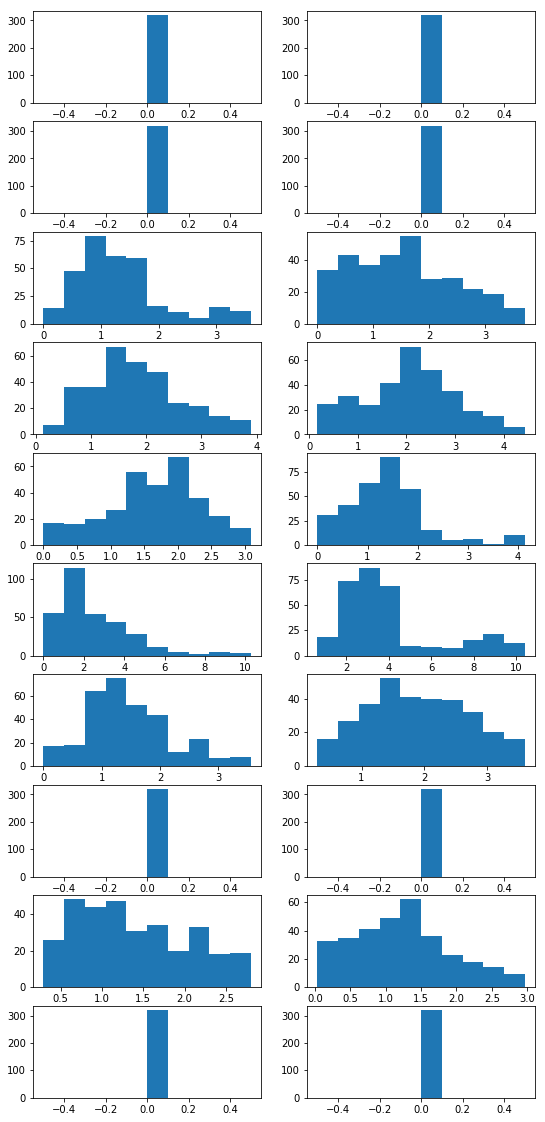

In [44]:
# %%
# Plot activation of neurons
saved_model = 'modelxxx7'
example_num = 40

# %%
# Fit training data
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    input_shape = [example_num, 40, 320, 1]
    weight_file = 'w1.npy'
    bias_file = 'b1.npy'
    strides = [4, 5]
    x = tf.placeholder(tf.float32, input_shape, name='x')
    ae1 = add_encoder_layer_with_weight(x, weight_file, bias_file, strides)
    
    H_weight_file = 'w2.npy'
    H_bias_file = 'b2.npy'
    P_weight_file = 'w3.npy'
    P_bias_file = 'b3.npy'
    strides = [3, 3]
    pred1 = add_predict_layer_with_weight(ae1['z'], H_weight_file, H_bias_file, P_weight_file, P_bias_file, strides)
    
    weight_file = 'w4.npy'
    bias_file = 'b4.npy'
    strides = [1, 1]
    ae2 = add_encoder_layer_with_weight(pred1['z'], weight_file, bias_file, strides)
    
    H_weight_file = 'w5.npy'
    H_bias_file = 'b5.npy'
    P_weight_file = 'w6.npy'
    P_bias_file = 'b6.npy'
    strides = [1, 1]
    pred2 = add_predict_layer_with_weight(ae2['z'], H_weight_file, H_bias_file, P_weight_file, P_bias_file, strides)
    
    n_filters = 70
    filter_size = [1, 8]
    strides = [1, 1]
    ae = add_encoder_layer(pred2['z'], n_filters, filter_size, strides, 0.5)
    
    sess = tf.Session()
    
    # reload the pretrained model
    restorer = tf.train.Saver()
    restorer.restore(sess, 'model/' + saved_model)
    
    start = int(rnd.random()*(40000-example_num-1))
    test_xs = train_images[start:(start+example_num), :, :, :]
    test_xs_norm = test_xs
    steps_test = train_steps[start:(start+example_num-1)]
    angles_test = train_angles[start:(start+example_num-1)]
    print('step commands are', steps_test)
    print('angle commands are', angles_test)
    z1 = sess.run(ae['z'], feed_dict={x: test_xs_norm})

    test_xs2 = train_images2[start:(start+example_num), :, :, :]
    test_xs_norm = test_xs2
    steps_test = train_steps2[start:(start+example_num-1)]
    angles_test = train_angles2[start:(start+example_num-1)]
    print('step commands are', steps_test)
    print('angle commands are', angles_test)
    z2 = sess.run(ae['z'], feed_dict={x: test_xs_norm})

    print('z1.shape =', z1.shape)
    print('z2.shape =', z2.shape)

shape = z1.shape
tmp1 = np.reshape(z1, (shape[0]*shape[1]*shape[2], shape[3]))
# plt.hist(tmp1[:, 0])
tmp2 = np.reshape(z2, (shape[0]*shape[1]*shape[2], shape[3]))
fig, axes = plt.subplots(10, 2, figsize=(9, 20))
for idx in range(10):
    axes[idx, 0].hist(tmp1[:, idx])
    axes[idx, 1].hist(tmp2[:, idx])

In [ ]:
saved_model = 'modelxxx8'
example_num = 1

# %%
# Fit training data
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    input_shape = [example_num, 40, 320, 1]
    weight_file = 'w1.npy'
    bias_file = 'b1.npy'
    strides = [4, 5]
    x1 = tf.placeholder(tf.float32, input_shape, name='x1')
    x2 = tf.placeholder(tf.float32, input_shape, name='x2')
    ae1_1 = add_encoder_layer_with_weight(x1, weight_file, bias_file, strides)
    ae1_2 = add_encoder_layer_with_weight(x2, weight_file, bias_file, strides)
    
    H_weight_file = 'w2.npy'
    H_bias_file = 'b2.npy'
    P_weight_file = 'w3.npy'
    P_bias_file = 'b3.npy'
    strides = [3, 3]
    pred1_1 = add_predict_layer_with_weight(ae1_1['z'], H_weight_file, H_bias_file, P_weight_file, P_bias_file, strides)
    pred1_2 = add_predict_layer_with_weight(ae1_2['z'], H_weight_file, H_bias_file, P_weight_file, P_bias_file, strides)
    
    weight_file = 'w4.npy'
    bias_file = 'b4.npy'
    strides = [1, 1]
    ae2_1 = add_encoder_layer_with_weight(pred1_1['z'], weight_file, bias_file, strides)
    ae2_2 = add_encoder_layer_with_weight(pred1_2['z'], weight_file, bias_file, strides)
    
    H_weight_file = 'w5.npy'
    H_bias_file = 'b5.npy'
    P_weight_file = 'w6.npy'
    P_bias_file = 'b6.npy'
    strides = [1, 1]
    pred2_1 = add_predict_layer_with_weight(ae2_1['z'], H_weight_file, H_bias_file, P_weight_file, P_bias_file, strides)
    pred2_2 = add_predict_layer_with_weight(ae2_2['z'], H_weight_file, H_bias_file, P_weight_file, P_bias_file, strides)
    
    weight_file = 'w7.npy'
    bias_file = 'b7.npy'
    strides = [1, 1]
    ae3_1 = add_encoder_layer_with_weight(pred2_1['z'], weight_file, bias_file, strides)
    ae3_2 = add_encoder_layer_with_weight(pred2_2['z'], weight_file, bias_file, strides)
    
    filter_size = [1, 8]
    strides = [1, 1]
    head_cell_n = 40
    place_cell_n = 30
    pred = add_predict_layer(ae3_1['z'], ae3_2['z'], filter_size, strides, head_cell_n, place_cell_n)
    
    sess = tf.Session()
    
    # initialize the weights or load the trained weights
#     sess.run(tf.global_variables_initializer())
    
    restorer = tf.train.Saver()
    restorer.restore(sess, 'model/' + saved_model)

    n_epochs = 10
    for epoch_i in range(n_epochs):
        for batch_i in range(train_images.shape[0]-1):
            train1 = train_images[batch_i:(batch_i+example_num), :, :, :]
            train2 = train_images[batch_i+1:(batch_i+1+example_num), :, :, :]
            train_step = train_steps[batch_i]
            train_angle = train_angles[batch_i]
            if train_step != 0:
                sess.run(pred['optimizer1'], feed_dict={x1: train1, x2: train2})
            if train_angle != 0:
                sess.run(pred['optimizer2'], feed_dict={x1: train1, x2: train2})
            if batch_i % 10000 == 0:
                cost1_val, cost2_val = sess.run([pred['cost1'], pred['cost2']], feed_dict={x1: train1, x2: train2})
                print(epoch_i, ':', batch_i, 'step = ', train_step, 'angle =', train_angle, ':1:cost1 =', cost1_val, "cost2 =", cost2_val)
        for batch_i in range(train_images.shape[0]-1):
            train1 = train_images2[batch_i:(batch_i+example_num), :, :, :]
            train2 = train_images2[batch_i+1:(batch_i+1+example_num), :, :, :]
            train_step = train_steps2[batch_i]
            train_angle = train_angles2[batch_i]
            if train_step != 0:
                sess.run(pred['optimizer1'], feed_dict={x1: train1, x2: train2})
            if train_angle != 0:
                sess.run(pred['optimizer2'], feed_dict={x1: train1, x2: train2})
            if batch_i % 10000 == 0:
                cost1_val, cost2_val = sess.run([pred['cost1'], pred['cost2']], feed_dict={x1: train1, x2: train2})
                print(epoch_i, ':', batch_i, 'step = ', train_step, 'angle =', train_angle, ':1:cost1 =', cost1_val, "cost2 =", cost2_val)

    w8, b8, w9, b9 = sess.run([pred['w2'], pred['b2'], pred['w3'], pred['b3']])
    print('w8.shape = ', w8.shape, 'b8.shape = ', b8.shape, 'w9.shape = ', w9.shape, 'b9.shape = ', b9.shape)
    np.save('model/w8.npy', w8)
    np.save('model/b8.npy', b8)
    np.save('model/w9.npy', w9)
    np.save('model/b9.npy', b9)
    
    saver = tf.train.Saver()
    save_path = saver.save(sess, 'model/' + saved_model)
    print("Model saved in file: %s" % save_path)

The input layer x has shape (1, 40, 320, 1)
The encoding layer z has shape (1, 9, 63, 10)
The input layer x has shape (1, 40, 320, 1)
The encoding layer z has shape (1, 9, 63, 10)
The input layer x has shape (1, 9, 63, 10)
The head_layer has shape (1, 3, 21, 40)
The place_layer has shape (1, 3, 21, 30)
The layer z has shape (1, 3, 21, 70)
The input layer x has shape (1, 9, 63, 10)
The head_layer has shape (1, 3, 21, 40)
The place_layer has shape (1, 3, 21, 30)
The layer z has shape (1, 3, 21, 70)
The input layer x has shape (1, 3, 21, 70)
The encoding layer z has shape (1, 1, 19, 70)
The input layer x has shape (1, 3, 21, 70)
The encoding layer z has shape (1, 1, 19, 70)
The input layer x has shape (1, 1, 19, 70)
The head_layer has shape (1, 1, 15, 40)
The place_layer has shape (1, 1, 15, 30)
The layer z has shape (1, 1, 15, 70)
The input layer x has shape (1, 1, 19, 70)
The head_layer has shape (1, 1, 15, 40)
The place_layer has shape (1, 1, 15, 30)
The layer z has shape (1, 1, 15, 70

# Head and Place Cells Test

In [3]:
# load test data
test_images = np.load('test_images.npy')
print(test_images.shape)
# test_mean_img = np.mean(test_images, axis=0)
# print('test_mean_img.shape =', test_mean_img.shape)
# plt.imshow(test_mean_img[:, :, 0], cmap='gray')

test_cmds = np.load('test_cmds.npy')
print(test_cmds.shape)
test_xs = test_cmds[:, 0]
test_x_set = set(test_xs)
print(test_xs.shape, len(test_x_set))
# print(test_x_set)
test_ys = test_cmds[:, 1]
test_y_set = set(test_ys)
print(test_ys.shape, len(test_y_set))
# print(test_y_set)
test_angles = test_cmds[:, 2]
test_angle_set = set(test_angles)
print(test_angles.shape, len(test_angle_set))
# print(test_angle_set)

(12096, 40, 320, 1)
(12096, 3)
(12096,) 24
(12096,) 14
(12096,) 36


In [4]:
head_map_4_head_cell = np.zeros((36, 40))
place_map_4_head_cell = np.zeros((14, 24, 40))
head_map_4_place_cell = np.zeros((36, 30))
place_map_4_place_cell = np.zeros((14, 24, 30))

saved_model = 'modelxxx8'
example_num = 1
batch_size = example_num

# %%
# Fit training data
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    input_shape = [example_num, 40, 320, 1]
    weight_file = 'w1.npy'
    bias_file = 'b1.npy'
    strides = [4, 5]
    x = tf.placeholder(tf.float32, input_shape, name='x')
    ae1 = add_encoder_layer_with_weight(x, weight_file, bias_file, strides)
    
    H_weight_file = 'w2.npy'
    H_bias_file = 'b2.npy'
    P_weight_file = 'w3.npy'
    P_bias_file = 'b3.npy'
    strides = [3, 3]
    pred1 = add_predict_layer_with_weight(ae1['z'], H_weight_file, H_bias_file, P_weight_file, P_bias_file, strides)
    
    weight_file = 'w4.npy'
    bias_file = 'b4.npy'
    strides = [1, 1]
    ae2 = add_encoder_layer_with_weight(pred1['z'], weight_file, bias_file, strides)
    
    H_weight_file = 'w5.npy'
    H_bias_file = 'b5.npy'
    P_weight_file = 'w6.npy'
    P_bias_file = 'b6.npy'
    strides = [1, 1]
    pred2 = add_predict_layer_with_weight(ae2['z'], H_weight_file, H_bias_file, P_weight_file, P_bias_file, strides)
    
    weight_file = 'w7.npy'
    bias_file = 'b7.npy'
    strides = [1, 1]
    ae3 = add_encoder_layer_with_weight(pred2['z'], weight_file, bias_file, strides)
    
    H_weight_file = 'w8.npy'
    H_bias_file = 'b8.npy'
    P_weight_file = 'w9.npy'
    P_bias_file = 'b9.npy'
    strides = [1, 1]
    pred = add_predict_layer_with_weight(ae3['z'], H_weight_file, H_bias_file, P_weight_file, P_bias_file, strides)
    
    sess = tf.Session()
    # load the trained weights
#     restorer = tf.train.Saver()
#     restorer.restore(sess, 'model/' + saved_model)
    
    for idx in range(test_images.shape[0]):
        batch_xs = test_images[(idx*batch_size):((idx+1)*batch_size), :, :, :]
    #     test_image = np.array([img - test_mean_img for img in batch_xs])
        test_image = batch_xs
        test_x = test_xs[(idx*batch_size):((idx+1)*batch_size)]
        test_y = test_ys[(idx*batch_size):((idx+1)*batch_size)]
        test_angle = test_angles[(idx*batch_size):((idx+1)*batch_size)]
        Head_val, Place_val = sess.run([pred['z1'], pred['z2']], feed_dict={x: test_image})
        print(idx, 'Head_val.shape =', Head_val.shape, 'Place_val.shape =', Place_val.shape)
        for idx2 in range(batch_size):
            head_map_4_head_cell[test_angle[idx2].astype(int), :] += np.mean(Head_val, (1, 2))[idx2, :]
            place_map_4_head_cell[(test_y[idx2]-3).astype(int), (test_x[idx2]-3).astype(int), :] += np.mean(Head_val, (1, 2))[idx2, :]
            head_map_4_place_cell[test_angle[idx2].astype(int), :] += np.mean(Place_val, (1, 2))[idx2, :]
            place_map_4_place_cell[(test_y[idx2]-3).astype(int), (test_x[idx2]-3).astype(int), :] += np.mean(Place_val, (1, 2))[idx2, :]

The input layer x has shape (1, 40, 320, 1)
The encoding layer z has shape (1, 9, 63, 10)
The input layer x has shape (1, 9, 63, 10)
The head_layer has shape (1, 3, 21, 40)
The place_layer has shape (1, 3, 21, 30)
The layer z has shape (1, 3, 21, 70)
The input layer x has shape (1, 3, 21, 70)
The encoding layer z has shape (1, 1, 19, 70)
The input layer x has shape (1, 1, 19, 70)
The head_layer has shape (1, 1, 15, 40)
The place_layer has shape (1, 1, 15, 30)
The layer z has shape (1, 1, 15, 70)
The input layer x has shape (1, 1, 15, 70)
The encoding layer z has shape (1, 1, 8, 70)
The input layer x has shape (1, 1, 8, 70)
The head_layer has shape (1, 1, 1, 40)
The place_layer has shape (1, 1, 1, 30)
The layer z has shape (1, 1, 1, 70)
0 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1

167 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
168 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
169 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
170 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
171 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
172 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
173 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
174 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
175 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
176 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
177 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
178 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
179 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
180 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
181 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1,

293 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
294 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
295 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
296 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
297 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
298 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
299 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
300 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
301 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
302 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
303 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
304 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
305 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
306 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
307 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1,

431 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
432 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
433 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
434 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
435 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
436 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
437 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
438 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
439 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
440 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
441 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
442 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
443 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
444 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
445 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1,

563 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
564 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
565 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
566 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
567 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
568 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
569 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
570 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
571 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
572 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
573 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
574 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
575 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
576 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
577 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1,

700 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
701 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
702 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
703 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
704 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
705 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
706 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
707 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
708 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
709 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
710 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
711 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
712 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
713 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
714 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1,

838 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
839 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
840 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
841 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
842 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
843 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
844 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
845 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
846 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
847 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
848 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
849 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
850 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
851 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
852 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1,

962 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
963 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
964 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
965 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
966 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
967 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
968 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
969 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
970 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
971 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
972 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
973 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
974 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
975 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
976 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1,

1110 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1111 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1112 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1113 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1114 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1115 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1116 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1117 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1118 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1119 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1120 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1121 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1122 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1123 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1124 Head_val.shape = (1, 1, 1, 40) Place_val.sh

1268 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1269 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1270 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1271 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1272 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1273 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1274 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1275 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1276 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1277 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1278 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1279 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1280 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1281 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1282 Head_val.shape = (1, 1, 1, 40) Place_val.sh

1419 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1420 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1421 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1422 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1423 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1424 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1425 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1426 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1427 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1428 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1429 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1430 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1431 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1432 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1433 Head_val.shape = (1, 1, 1, 40) Place_val.sh

1581 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1582 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1583 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1584 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1585 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1586 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1587 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1588 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1589 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1590 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1591 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1592 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1593 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1594 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1595 Head_val.shape = (1, 1, 1, 40) Place_val.sh

1742 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1743 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1744 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1745 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1746 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1747 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1748 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1749 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1750 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1751 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1752 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1753 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1754 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1755 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1756 Head_val.shape = (1, 1, 1, 40) Place_val.sh

1917 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1918 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1919 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1920 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1921 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1922 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1923 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1924 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1925 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1926 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1927 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1928 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1929 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1930 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
1931 Head_val.shape = (1, 1, 1, 40) Place_val.sh

2040 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2041 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2042 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2043 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2044 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2045 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2046 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2047 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2048 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2049 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2050 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2051 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2052 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2053 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2054 Head_val.shape = (1, 1, 1, 40) Place_val.sh

2170 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2171 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2172 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2173 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2174 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2175 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2176 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2177 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2178 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2179 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2180 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2181 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2182 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2183 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2184 Head_val.shape = (1, 1, 1, 40) Place_val.sh

2324 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2325 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2326 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2327 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2328 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2329 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2330 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2331 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2332 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2333 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2334 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2335 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2336 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2337 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2338 Head_val.shape = (1, 1, 1, 40) Place_val.sh

2460 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2461 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2462 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2463 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2464 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2465 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2466 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2467 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2468 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2469 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2470 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2471 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2472 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2473 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2474 Head_val.shape = (1, 1, 1, 40) Place_val.sh

2589 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2590 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2591 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2592 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2593 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2594 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2595 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2596 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2597 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2598 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2599 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2600 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2601 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2602 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2603 Head_val.shape = (1, 1, 1, 40) Place_val.sh

2754 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2755 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2756 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2757 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2758 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2759 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2760 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2761 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2762 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2763 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2764 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2765 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2766 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2767 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2768 Head_val.shape = (1, 1, 1, 40) Place_val.sh

2907 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2908 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2909 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2910 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2911 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2912 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2913 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2914 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2915 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2916 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2917 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2918 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2919 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2920 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
2921 Head_val.shape = (1, 1, 1, 40) Place_val.sh

3031 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3032 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3033 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3034 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3035 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3036 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3037 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3038 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3039 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3040 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3041 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3042 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3043 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3044 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3045 Head_val.shape = (1, 1, 1, 40) Place_val.sh

3163 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3164 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3165 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3166 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3167 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3168 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3169 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3170 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3171 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3172 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3173 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3174 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3175 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3176 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3177 Head_val.shape = (1, 1, 1, 40) Place_val.sh

3299 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3300 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3301 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3302 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3303 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3304 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3305 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3306 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3307 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3308 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3309 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3310 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3311 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3312 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3313 Head_val.shape = (1, 1, 1, 40) Place_val.sh

3431 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3432 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3433 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3434 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3435 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3436 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3437 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3438 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3439 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3440 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3441 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3442 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3443 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3444 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3445 Head_val.shape = (1, 1, 1, 40) Place_val.sh

3569 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3570 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3571 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3572 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3573 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3574 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3575 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3576 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3577 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3578 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3579 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3580 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3581 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3582 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3583 Head_val.shape = (1, 1, 1, 40) Place_val.sh

3693 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3694 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3695 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3696 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3697 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3698 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3699 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3700 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3701 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3702 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3703 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3704 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3705 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3706 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3707 Head_val.shape = (1, 1, 1, 40) Place_val.sh

3817 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3818 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3819 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3820 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3821 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3822 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3823 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3824 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3825 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3826 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3827 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3828 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3829 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3830 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3831 Head_val.shape = (1, 1, 1, 40) Place_val.sh

3944 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3945 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3946 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3947 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3948 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3949 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3950 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3951 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3952 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3953 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3954 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3955 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3956 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3957 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
3958 Head_val.shape = (1, 1, 1, 40) Place_val.sh

4069 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4070 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4071 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4072 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4073 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4074 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4075 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4076 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4077 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4078 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4079 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4080 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4081 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4082 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4083 Head_val.shape = (1, 1, 1, 40) Place_val.sh

4203 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4204 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4205 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4206 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4207 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4208 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4209 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4210 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4211 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4212 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4213 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4214 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4215 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4216 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4217 Head_val.shape = (1, 1, 1, 40) Place_val.sh

4340 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4341 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4342 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4343 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4344 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4345 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4346 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4347 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4348 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4349 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4350 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4351 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4352 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4353 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4354 Head_val.shape = (1, 1, 1, 40) Place_val.sh

4471 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4472 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4473 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4474 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4475 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4476 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4477 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4478 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4479 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4480 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4481 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4482 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4483 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4484 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4485 Head_val.shape = (1, 1, 1, 40) Place_val.sh

4601 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4602 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4603 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4604 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4605 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4606 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4607 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4608 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4609 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4610 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4611 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4612 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4613 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4614 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4615 Head_val.shape = (1, 1, 1, 40) Place_val.sh

4733 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4734 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4735 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4736 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4737 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4738 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4739 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4740 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4741 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4742 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4743 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4744 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4745 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4746 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4747 Head_val.shape = (1, 1, 1, 40) Place_val.sh

4866 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4867 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4868 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4869 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4870 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4871 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4872 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4873 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4874 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4875 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4876 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4877 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4878 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4879 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4880 Head_val.shape = (1, 1, 1, 40) Place_val.sh

4997 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4998 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
4999 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5000 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5001 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5002 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5003 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5004 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5005 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5006 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5007 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5008 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5009 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5010 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5011 Head_val.shape = (1, 1, 1, 40) Place_val.sh

5123 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5124 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5125 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5126 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5127 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5128 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5129 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5130 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5131 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5132 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5133 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5134 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5135 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5136 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5137 Head_val.shape = (1, 1, 1, 40) Place_val.sh

5292 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5293 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5294 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5295 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5296 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5297 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5298 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5299 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5300 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5301 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5302 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5303 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5304 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5305 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5306 Head_val.shape = (1, 1, 1, 40) Place_val.sh

5463 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5464 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5465 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5466 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5467 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5468 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5469 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5470 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5471 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5472 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5473 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5474 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5475 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5476 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5477 Head_val.shape = (1, 1, 1, 40) Place_val.sh

5596 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5597 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5598 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5599 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5600 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5601 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5602 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5603 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5604 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5605 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5606 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5607 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5608 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5609 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5610 Head_val.shape = (1, 1, 1, 40) Place_val.sh

5731 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5732 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5733 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5734 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5735 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5736 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5737 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5738 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5739 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5740 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5741 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5742 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5743 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5744 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5745 Head_val.shape = (1, 1, 1, 40) Place_val.sh

5869 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5870 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5871 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5872 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5873 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5874 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5875 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5876 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5877 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5878 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5879 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5880 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5881 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5882 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
5883 Head_val.shape = (1, 1, 1, 40) Place_val.sh

6009 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6010 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6011 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6012 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6013 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6014 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6015 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6016 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6017 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6018 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6019 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6020 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6021 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6022 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6023 Head_val.shape = (1, 1, 1, 40) Place_val.sh

6148 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6149 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6150 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6151 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6152 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6153 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6154 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6155 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6156 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6157 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6158 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6159 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6160 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6161 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6162 Head_val.shape = (1, 1, 1, 40) Place_val.sh

6287 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6288 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6289 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6290 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6291 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6292 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6293 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6294 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6295 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6296 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6297 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6298 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6299 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6300 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6301 Head_val.shape = (1, 1, 1, 40) Place_val.sh

6429 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6430 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6431 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6432 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6433 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6434 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6435 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6436 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6437 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6438 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6439 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6440 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6441 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6442 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6443 Head_val.shape = (1, 1, 1, 40) Place_val.sh

6564 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6565 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6566 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6567 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6568 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6569 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6570 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6571 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6572 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6573 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6574 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6575 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6576 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6577 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6578 Head_val.shape = (1, 1, 1, 40) Place_val.sh

6705 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6706 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6707 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6708 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6709 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6710 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6711 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6712 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6713 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6714 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6715 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6716 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6717 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6718 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6719 Head_val.shape = (1, 1, 1, 40) Place_val.sh

6849 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6850 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6851 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6852 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6853 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6854 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6855 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6856 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6857 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6858 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6859 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6860 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6861 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6862 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6863 Head_val.shape = (1, 1, 1, 40) Place_val.sh

6988 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6989 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6990 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6991 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6992 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6993 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6994 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6995 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6996 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6997 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6998 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
6999 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7000 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7001 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7002 Head_val.shape = (1, 1, 1, 40) Place_val.sh

7129 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7130 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7131 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7132 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7133 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7134 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7135 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7136 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7137 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7138 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7139 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7140 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7141 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7142 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7143 Head_val.shape = (1, 1, 1, 40) Place_val.sh

7269 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7270 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7271 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7272 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7273 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7274 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7275 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7276 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7277 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7278 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7279 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7280 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7281 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7282 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7283 Head_val.shape = (1, 1, 1, 40) Place_val.sh

7408 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7409 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7410 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7411 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7412 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7413 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7414 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7415 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7416 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7417 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7418 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7419 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7420 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7421 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7422 Head_val.shape = (1, 1, 1, 40) Place_val.sh

7545 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7546 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7547 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7548 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7549 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7550 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7551 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7552 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7553 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7554 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7555 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7556 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7557 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7558 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7559 Head_val.shape = (1, 1, 1, 40) Place_val.sh

7684 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7685 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7686 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7687 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7688 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7689 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7690 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7691 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7692 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7693 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7694 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7695 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7696 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7697 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7698 Head_val.shape = (1, 1, 1, 40) Place_val.sh

7826 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7827 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7828 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7829 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7830 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7831 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7832 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7833 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7834 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7835 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7836 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7837 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7838 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7839 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7840 Head_val.shape = (1, 1, 1, 40) Place_val.sh

7966 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7967 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7968 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7969 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7970 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7971 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7972 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7973 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7974 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7975 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7976 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7977 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7978 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7979 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
7980 Head_val.shape = (1, 1, 1, 40) Place_val.sh

8110 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8111 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8112 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8113 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8114 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8115 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8116 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8117 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8118 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8119 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8120 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8121 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8122 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8123 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8124 Head_val.shape = (1, 1, 1, 40) Place_val.sh

8244 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8245 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8246 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8247 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8248 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8249 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8250 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8251 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8252 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8253 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8254 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8255 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8256 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8257 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8258 Head_val.shape = (1, 1, 1, 40) Place_val.sh

8385 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8386 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8387 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8388 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8389 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8390 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8391 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8392 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8393 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8394 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8395 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8396 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8397 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8398 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8399 Head_val.shape = (1, 1, 1, 40) Place_val.sh

8522 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8523 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8524 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8525 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8526 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8527 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8528 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8529 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8530 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8531 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8532 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8533 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8534 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8535 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8536 Head_val.shape = (1, 1, 1, 40) Place_val.sh

8652 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8653 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8654 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8655 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8656 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8657 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8658 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8659 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8660 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8661 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8662 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8663 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8664 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8665 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8666 Head_val.shape = (1, 1, 1, 40) Place_val.sh

8782 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8783 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8784 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8785 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8786 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8787 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8788 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8789 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8790 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8791 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8792 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8793 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8794 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8795 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8796 Head_val.shape = (1, 1, 1, 40) Place_val.sh

8914 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8915 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8916 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8917 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8918 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8919 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8920 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8921 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8922 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8923 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8924 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8925 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8926 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8927 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
8928 Head_val.shape = (1, 1, 1, 40) Place_val.sh

9059 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9060 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9061 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9062 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9063 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9064 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9065 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9066 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9067 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9068 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9069 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9070 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9071 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9072 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9073 Head_val.shape = (1, 1, 1, 40) Place_val.sh

9200 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9201 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9202 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9203 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9204 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9205 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9206 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9207 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9208 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9209 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9210 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9211 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9212 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9213 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9214 Head_val.shape = (1, 1, 1, 40) Place_val.sh

9321 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9322 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9323 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9324 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9325 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9326 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9327 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9328 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9329 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9330 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9331 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9332 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9333 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9334 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9335 Head_val.shape = (1, 1, 1, 40) Place_val.sh

9450 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9451 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9452 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9453 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9454 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9455 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9456 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9457 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9458 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9459 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9460 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9461 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9462 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9463 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9464 Head_val.shape = (1, 1, 1, 40) Place_val.sh

9633 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9634 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9635 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9636 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9637 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9638 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9639 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9640 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9641 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9642 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9643 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9644 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9645 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9646 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9647 Head_val.shape = (1, 1, 1, 40) Place_val.sh

9770 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9771 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9772 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9773 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9774 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9775 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9776 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9777 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9778 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9779 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9780 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9781 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9782 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9783 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9784 Head_val.shape = (1, 1, 1, 40) Place_val.sh

9891 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9892 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9893 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9894 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9895 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9896 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9897 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9898 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9899 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9900 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9901 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9902 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9903 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9904 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
9905 Head_val.shape = (1, 1, 1, 40) Place_val.sh

10017 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10018 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10019 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10020 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10021 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10022 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10023 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10024 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10025 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10026 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10027 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10028 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10029 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10030 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10031 Head_val.shape = (1, 1, 1, 4

10146 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10147 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10148 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10149 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10150 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10151 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10152 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10153 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10154 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10155 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10156 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10157 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10158 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10159 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10160 Head_val.shape = (1, 1, 1, 4

10266 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10267 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10268 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10269 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10270 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10271 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10272 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10273 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10274 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10275 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10276 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10277 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10278 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10279 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10280 Head_val.shape = (1, 1, 1, 4

10445 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10446 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10447 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10448 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10449 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10450 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10451 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10452 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10453 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10454 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10455 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10456 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10457 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10458 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10459 Head_val.shape = (1, 1, 1, 4

10582 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10583 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10584 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10585 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10586 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10587 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10588 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10589 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10590 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10591 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10592 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10593 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10594 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10595 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10596 Head_val.shape = (1, 1, 1, 4

10714 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10715 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10716 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10717 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10718 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10719 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10720 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10721 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10722 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10723 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10724 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10725 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10726 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10727 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10728 Head_val.shape = (1, 1, 1, 4

10838 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10839 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10840 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10841 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10842 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10843 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10844 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10845 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10846 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10847 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10848 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10849 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10850 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10851 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10852 Head_val.shape = (1, 1, 1, 4

10966 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10967 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10968 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10969 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10970 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10971 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10972 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10973 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10974 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10975 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10976 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10977 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10978 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10979 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
10980 Head_val.shape = (1, 1, 1, 4

11145 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11146 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11147 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11148 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11149 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11150 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11151 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11152 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11153 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11154 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11155 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11156 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11157 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11158 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11159 Head_val.shape = (1, 1, 1, 4

11279 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11280 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11281 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11282 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11283 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11284 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11285 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11286 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11287 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11288 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11289 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11290 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11291 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11292 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11293 Head_val.shape = (1, 1, 1, 4

11412 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11413 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11414 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11415 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11416 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11417 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11418 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11419 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11420 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11421 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11422 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11423 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11424 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11425 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11426 Head_val.shape = (1, 1, 1, 4

11550 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11551 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11552 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11553 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11554 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11555 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11556 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11557 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11558 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11559 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11560 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11561 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11562 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11563 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11564 Head_val.shape = (1, 1, 1, 4

11690 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11691 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11692 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11693 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11694 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11695 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11696 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11697 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11698 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11699 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11700 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11701 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11702 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11703 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11704 Head_val.shape = (1, 1, 1, 4

11822 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11823 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11824 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11825 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11826 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11827 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11828 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11829 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11830 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11831 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11832 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11833 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11834 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11835 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11836 Head_val.shape = (1, 1, 1, 4

11960 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11961 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11962 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11963 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11964 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11965 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11966 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11967 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11968 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11969 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11970 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11971 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11972 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11973 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 30)
11974 Head_val.shape = (1, 1, 1, 4

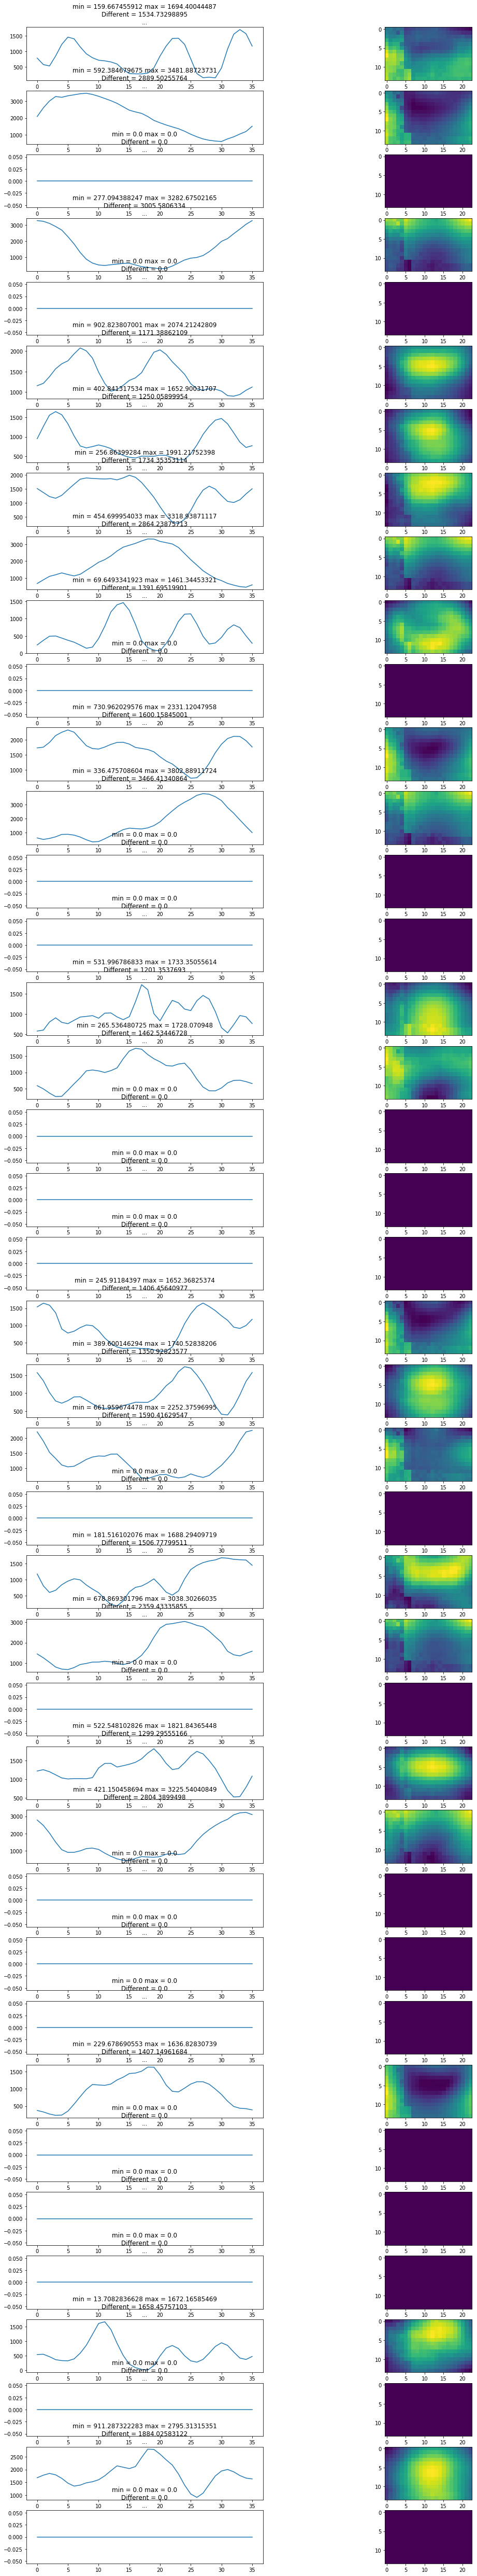

In [5]:
fig, axs = plt.subplots(40, 2, figsize=(18, 90))
for example_i in range(40):
    axs[example_i][0].plot(np.abs(head_map_4_head_cell[:, example_i]))
    min_val = min(head_map_4_head_cell[:, example_i])
    max_val = max(head_map_4_head_cell[:, example_i])
    axs[example_i][0].set_title('min = ' + str(min_val) + ' max = ' + str(max_val) + '\nDifferent = ' + str(max_val-min_val) + '\n...')
    axs[example_i][1].imshow(np.abs(place_map_4_head_cell[:, 0:23, example_i]))
plt.show()

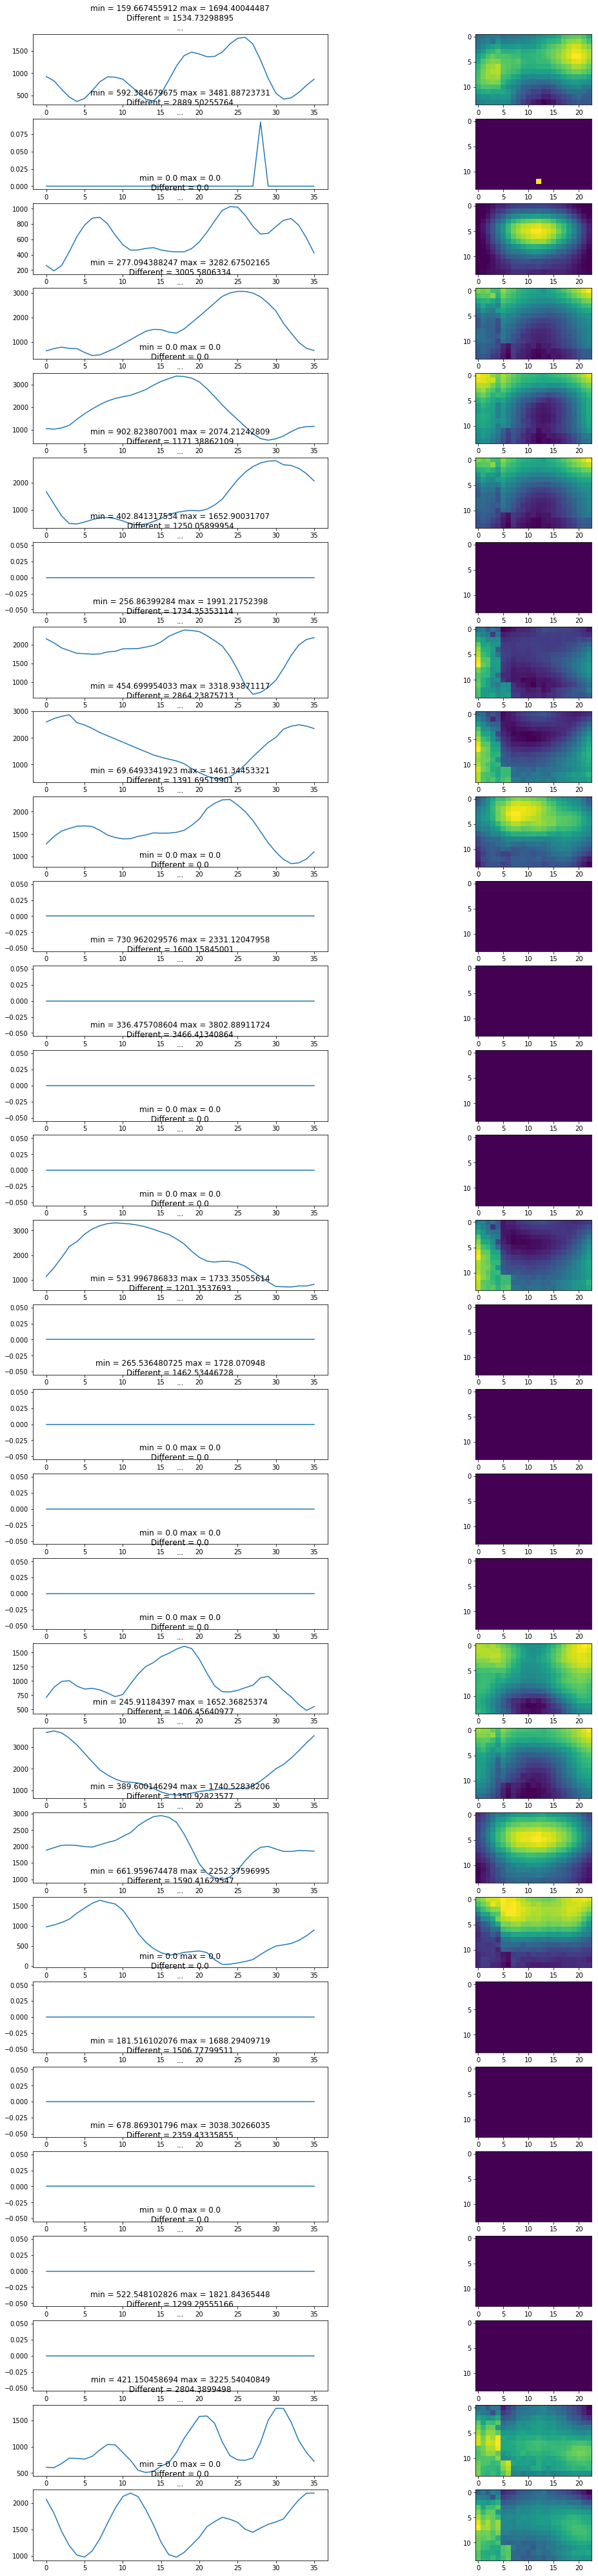

In [6]:
fig, axs = plt.subplots(30, 2, figsize=(18, 72))
for example_i in range(30):
    axs[example_i][0].plot(np.abs(head_map_4_place_cell[:, example_i]))
    min_val = min(head_map_4_head_cell[:, example_i])
    max_val = max(head_map_4_head_cell[:, example_i])
    axs[example_i][0].set_title('min = ' + str(min_val) + ' max = ' + str(max_val) + '\nDifferent = ' + str(max_val-min_val) + '\n...')
    axs[example_i][1].imshow(np.abs(place_map_4_place_cell[:, 0:23, example_i]))
plt.show()